# Sensitivity Analysis Made Easy with the EMA Workbench

*Google Colab version*

This is the main notebook of the workshop on *sensitivity analysis* (SA) at the Social Simulation Festival 2021. Here we will demonstrate how to do Variance-based SA also know as [Sobol SA](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis) on a relatively simple model [virus on network](https://ccl.northwestern.edu/netlogo/models/VirusonaNetwork). The idea is that you reuse (read copy-paste) this code your own model. Therefore, we tried to keep simple and avoid extensive side steps from.

This notebook is tuned to be run on [Google Colab](https://colab.research.google.com/) and has a couple of extra lines of code. If you want to use it on your local machine please use `sa_demo_local_machine.ipynb`.

The core packages used in this notebook are [Mesa](https://mesa.readthedocs.io/en/stable/) to define an ABM model in Python, [EMA Workbench](https://emaworkbench.readthedocs.io/en/latest/) to design and run experiments, [SALib](https://salib.readthedocs.io/en/latest/) to conduct SA (within EMA Workbench). Also, we used one pretty plotting function of [pyNetLogo](https://pynetlogo.readthedocs.io/en/latest/).

The notebook follows a simplified SA workflow and has 5 sections-steps:

<img src="img/workflow.png"/>

## 0. Installations and imports

In [35]:
# Clone the repo to make its file available for Google Colab
!git clone https://github.com/BROSE-Uninc/SSF2021.git

In [36]:
# Install necessary packages
!pip install ema_workbench mesa ipyparallel SALib &> /dev/null

In [7]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

# Import EMA Workbench modules 
from ema_workbench import (ReplicatorModel, RealParameter, BooleanParameter, IntegerParameter, Constant, TimeSeriesOutcome, perform_experiments, save_results, ema_logging)

# Initialize logger to keep track of experiments run
ema_logging.log_to_stderr(ema_logging.INFO)

# Import Mesa virus on network model
from virus_on_network import model

## 1. Load the model

The very first step of SA with EMA Workbench is to define or "load" the model as a function. That is, EMA Workbench treats all models as functions (read *black box*). They are supposed to have **inputs** (parameters, constants, uncertainties and policy levers) and **outputs** (outcomes, KPIs). The model structure is not interesting for EMA Workbench. It may be something simple as `def func(x)` which just returns x + 1.

Our model has quite an extensive set of **8 inputs** model parameters (read more about the model [here](https://github.com/projectmesa/mesa/tree/master/examples/virus_on_network)). Their names are pretty self-explanatory, but let's quickly go through them:

1. `num_nodes` - number of network nodes,
2. `avg_node_degree` - average node degree,
3. `initial_outbreak_size` - initial number of infected nodes,
4. `virus_spread_chance` - chance of the spread of the virus,
5. `virus_check_frequency` - how often node checks,
6. `recovery_chance` - how likely the node recovers,
7. `gain_resistance_chance` - what is the chance that node get resistance,
8. `steps` - number of steps.

And **4 outputs** model outcomes which correspond to a simple SIR model:
1. `Susceptible` - number of agents in susceptible state, 
2. `Infected` - number of agents in infected state,
3. `Resistant` - number of agents in resistant state,,
4. `TIME` - to keep track of simulation time.

In [8]:
# Setting up the model as a function
def model_virus_on_network(num_nodes=1, 
                           avg_node_degree=1, 
                           initial_outbreak_size=1, 
                           virus_spread_chance=1, 
                           virus_check_frequency=1, 
                           recovery_chance=1, 
                           gain_resistance_chance=1,
                           steps=10):
    
    from virus_on_network import model
    
    # Initialising the model
    virus_on_network = model.VirusOnNetwork(num_nodes=num_nodes, 
                                            avg_node_degree=avg_node_degree, 
                                            initial_outbreak_size=initial_outbreak_size, 
                                            virus_spread_chance=virus_spread_chance, 
                                            virus_check_frequency=virus_check_frequency, 
                                            recovery_chance=recovery_chance, 
                                            gain_resistance_chance=gain_resistance_chance)
                
    # Run the model steps times
    virus_on_network.run_model(steps)

    # Get model outcomes
    outcomes = virus_on_network.datacollector.get_model_vars_dataframe()
    
    # Return model outcomes
    return {'TIME' : list(range(steps + 1)),
            "Infected" : outcomes["Infected"].tolist(),
            "Susceptible" : outcomes["Susceptible"].tolist(),
            "Resistant" : outcomes["Resistant"].tolist()}

Now, let's parameterize and test out our Mesa model. What is supposed to happen? First, we shouldn't get any error 😅. Second, after we run `model_virus_on_network` function it has to give us a set of model outcomes. Let's try.

In [9]:
# Parametrize the model
num_nodes = 30
avg_node_degree = 3
initial_outbreak_size = 1
virus_spread_chance = 0.4
virus_check_frequency = 0.2
recovery_chance = 0.4
gain_resistance_chance = 0.3
steps = 10

model_virus_on_network(num_nodes=num_nodes, 
                       avg_node_degree=avg_node_degree, 
                       initial_outbreak_size=initial_outbreak_size, 
                       virus_spread_chance=virus_spread_chance, 
                       virus_check_frequency=virus_check_frequency, 
                       recovery_chance=recovery_chance, 
                       gain_resistance_chance=gain_resistance_chance,
                       steps=steps)

{'TIME': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Infected': [1, 6, 12, 20, 23, 24, 25, 22, 19, 22, 20],
 'Susceptible': [29, 24, 18, 10, 6, 5, 4, 6, 9, 6, 6],
 'Resistant': [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 4]}

Great success 🥳! Let's visualize how the Mesa model outcomes will look like with this parameter set (for this we need to run `run.py` in ).

<img src="img/run.png"/>

## 2. Design experiments

Now it's time to design experiments. What does it mean? Well, we have to specify:

* **which model parameters** aka *inputs* are we going to sample, what are their **ranges**, and random **distributions**,
* what we will keep as **constants** and do not change over the model run,
* and finally which **outcomes** we want to observe.

It's an important step in SA workflow and we have to be careful. Because if parameter ranges are too narrow or they're sampled from e.g. a Normal distribution, there is a chance that you'll overlook import model behavior. This is why model parameters are named **uncertainties** in the EMA Workbench. We often do not know parameter vales and how to explore many plausible options.

Now let's talk about "tech" part. First we have to initialize an instance of EMA Workbench called `ReplicatorModel`. This is how we "connect" EMA Workbench to our Python model. We have to pass a name of our model to `ReplicatorModel`, and also pass the function that we defined previously.

In [10]:
# Instantiate and pass the model 
model = ReplicatorModel('VirusOnNetwork', function=model_virus_on_network)

Second, let's access the model and write down its attributes. Down below you can see that we have different classes for different types of parameters: `IntegerParameter`, `RealParameter`. We use the first one for integer parameters and the second for floats. To specify a parameter we have to pass it a name, left and right boundaries for sampling. As you can see, we don't to the same for `Constants`. There you have to specify only one value. Since our model it's not static and outcomes differ over time, we have to call `TimeSeriesOutcome`. Finally we need to specify how many replications do we want to have. Rule of thumb here, let's go with 10 😎.

In [11]:
# Define model parameters and their ranges to be sampled
model.uncertainties = [IntegerParameter("num_nodes", 10, 100),
                       IntegerParameter("avg_node_degree", 2, 8),
                       RealParameter("virus_spread_chance", 0.1, 1),
                       RealParameter("virus_check_frequency", 0.1, 1),
                       RealParameter("recovery_chance", 0.1, 1),
                       RealParameter("gain_resistance_chance", 0.1, 1)]

# Define model parameters that will remain constant
model.constants = [Constant("initial_outbreak_size", 1),
                   Constant('steps', 30)]

# Define model outcomes
model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('Infected'),
                  TimeSeriesOutcome('Susceptible'),
                  TimeSeriesOutcome('Resistant')]

# Define the number of replications
model.replications = 10

## 3. Run the model

Now, we're all set to run the model. The syntax here is pretty straightforward: we call `perform_experiments`, passing it a model instance and specify how many `scenarios` we need. Depending on the number of scenarios EMA Workbench samples the parameters. As a result, the more scenarios you pass, the more parameter combinations you get. One more attribute here is the type of `uncertainty_sampling`. Some SA methods require a specific way of how parameters should be sampled, e.g. Sobol SA. That's why we have to specify it here.

Important thing to remember: Sobol SA requires a relatively **large sample size**. As [docs](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html#Using-SALib-for-sensitivity-analysis) say, to calculate first-order, second-order and total sensitivity indices, we need to have sample size of n(2p+2), where p is the number of input parameters, and n is a baseline sample size which should be large enough to stabilize the estimation of the indices.

In [13]:
# Run experiments with the aforementioned parameters and outputs
results = perform_experiments(models=model, scenarios=100)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [14]:
# Get the results
experiments, outcomes = results

In [15]:
experiments.head()

,avg_node_degree,gain_resistance_chance,num_nodes,recovery_chance,virus_check_frequency,virus_spread_chance,scenario,policy,model
0,7.0,0.298871,92.0,0.458710,0.634829,0.363365,0,None,VirusOnNetwork
1,5.0,0.376038,28.0,0.368766,0.813662,0.934164,1,None,VirusOnNetwork
2,4.0,0.980817,14.0,0.966896,0.688965,0.239981,2,None,VirusOnNetwork
3,6.0,0.770224,64.0,0.194533,0.663664,0.910286,3,None,VirusOnNetwork
4,6.0,0.136510,62.0,0.137513,0.562209,0.958909,4,None,VirusOnNetwork


In [16]:
outcomes.keys()

dict_keys(['TIME', 'Infected', 'Susceptible', 'Resistant'])

Often it is a good idea to save the results of a lengthy run and open up it next day 🥱. Great that EMA Workbench has such a feature.

### Epic save

<center><img src="img/save.jpg" width=200 height=260/><center>

In [17]:
from ema_workbench.util.utilities import save_results, load_results
import os

In [18]:
# Creaet a directory to store the results
directory = 'results/virus_on_network'
if not os.path.exists(directory):
    os.makedirs(directory)

In [19]:
# Save the results
save_results(results, 'results/virus_on_network/results.tar.gz')

[MainProcess/INFO] results saved successfully to c:\Users\Mikhail\Google Drive\ssf2021\results\virus_on_network\results.tar.gz


In [20]:
# Load the results
results = load_results('results/virus_on_network/results.tar.gz')

[MainProcess/INFO] results loaded succesfully from c:\Users\Mikhail\Google Drive\ssf2021\results\virus_on_network\results.tar.gz


In [21]:
experiments, outcomes = results

### A bit of preprocessing

Before we proceed further, we have to do a bit of preprocessing. Let's take a closer look at the outcomes. We have 4 outcomes, 1400 scenarios, 10 replications and we run the model for 30 steps. This is what you see down below:

In [22]:
print(random.choice(list(outcomes)))
outcomes[random.choice(list(outcomes))].shape

Infected


(100, 10, 31)

To simplify our life 😅, let's take a mean over all replications that we had. 

In [23]:
mean_outcomes = {key:np.mean(outcomes[key],axis=1) for key in outcomes.keys()}
mean_results = (experiments.copy(), mean_outcomes)

In [24]:
# Now the shape of this array doesn't have 10 in it  
mean_outcomes[random.choice(list(outcomes))].shape

(100, 31)

### Visuals!

In [25]:
from ema_workbench.analysis.plotting import lines

C:\Users\Mikhail\anaconda3\envs\env\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


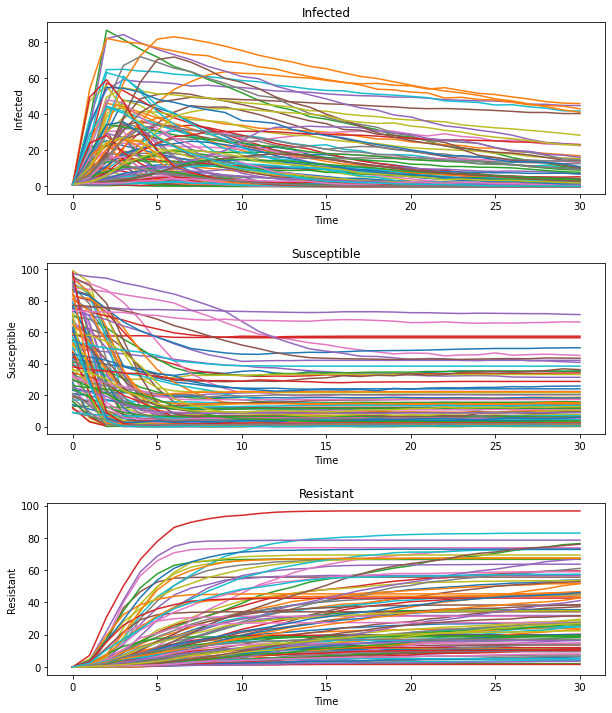

In [27]:
plt.rcParams['figure.figsize'] = [10, 12]
figure = lines(experiments, mean_outcomes)
plt.savefig('img/outcomes.png', dpi=300)

## 4. Do sensitivity analysis

Finally, we're here 🧙. EMA Workbench and SALib have different methods available for sampling and SA. Here we're going to use Variance-based Sensitivity Analysis also known as Sobol (by the surname of its author). Take a look at other options available there. As usual the most complex task here is to find out whether your model fits the method. As Confucius said "*If you found a method that fits your problem within an hour, you're either a method developer or most probably bamboozled yourself.*" 
For now, let's imagine that we found the right method and it is Sobol.

The *tech* part here is relatively straightforward:

1. Specify a *problem*, or simply say what model parameters did you sample,
2. Select an *outcome* of interest, yes, we have to analyze the impact outcome by outcome,
3. Run the analysis.  

In [21]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from src.plot import plot_sobol_indices
sns.set_style('white')

In [16]:
# Specify the problem
problem = get_SALib_problem(model.uncertainties)

In [17]:
# Select and normalize an outcome
normalized_resistant = (mean_outcomes['Resistant'][:,-1] / experiments['num_nodes']).to_numpy()

In [19]:
# Perform Sobol SA
Si = sobol.analyze(problem=problem, Y=normalized_resistant,
                   calc_second_order=True, print_to_console=False)

# Get scores by type 
Si_filter = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}

# Create a DataFrame out of them
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

# Get indices and error bars
indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

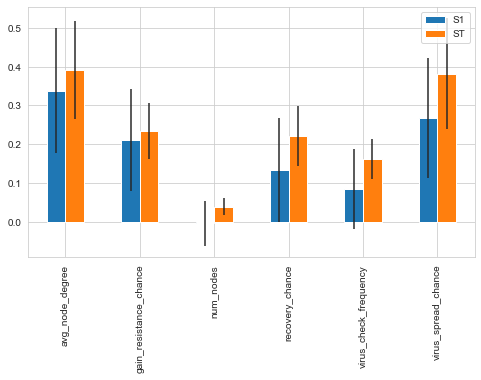

In [29]:
# Plot the results as a barplot
fig, ax = plt.subplots(1)
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

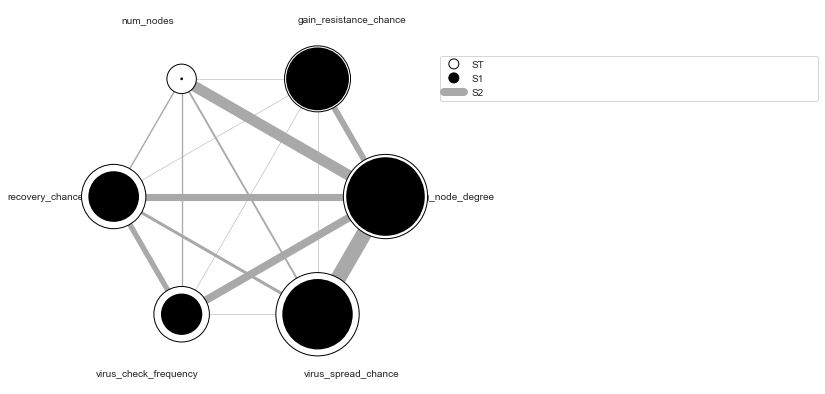

In [22]:
# Even a nice plot
fig = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

## 5. Interpretation of results